# Analysis of Disparate Impact based on gender and number of publications

In [102]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from metrics import disparate_impact
import matplotlib.pyplot as plt
import matplotlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset preparation

In [103]:
ita_prof = pd.read_csv('../processed_data/ita_informatics.csv', index_col = 0)

In [104]:
se = pd.read_csv("../processed_data/merge.csv")

In [105]:
ita_prof.head()

,Genere,fascia_id_2012,fascia_id_2013,fascia_id_2014,fascia_id_2015,fascia_id_2016,fascia_id_2017,fascia_id_2018,fascia_id_2019,fascia_id_2020,...,citations_1947,citations_1950,citations_1951,citations_2024,citations_1948,citations_1937,citations_1902,citations_1904,citations_1908,citations_1939
0,1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Aggregate papers

In [106]:
def aggregate_cols(df, param, col_name, year):
  df[col_name] = 0
  for c in df.columns:
    if param in c:
      current_year = c.split('_')[1]
      if int(current_year) <= year:
        df[col_name] = df[col_name] + df[c]
  return df

In [107]:
for i in range(2018, 2024):
  ita_prof = aggregate_cols(ita_prof, 'papers', f'PapersTo{i}', i)
  se = aggregate_cols(se, 'papers', f'PapersTo{i}', i)

### Aggregate citations

In [108]:
for i in range(2018, 2024):
  ita_prof = aggregate_cols(ita_prof, 'citations', f'CitationsTo{i}', i)
  se = aggregate_cols(se, 'citations', f'CitationsTo{i}', i)

## Disparate Impact on number of publications

In [109]:
def create_entry(year, group, paper_class, discard_role, median):
    positive_label = 2 if discard_role == 1 else 1
    entry = {}
    entry['year'] = year
    entry['paper_class'] = paper_class
    entry['group_size_men'] = group[group['Genere'] == 1].shape[0]
    entry['group_size_women'] = group[group['Genere'] == 0].shape[0]
    entry['pos_class_men'] = group[(group['Genere'] == 1)&(group[f'fascia_id_{i}'] == positive_label)].shape[0]
    entry['pos_class_women'] = group[(group['Genere'] == 0)&(group[f'fascia_id_{i}'] == positive_label)].shape[0]
    entry['q3'] = median
    try:
        entry['DI'] = disparate_impact(group[group[f'fascia_id_{i}'] != discard_role], {'Genere': 0}, f'fascia_id_{i}', positive_label)
    except ZeroDivisionError:
        print(f'ZeroDivisionError for year {year} and role {discard_role}')
        entry['DI'] = 0
    return entry


def compute_di(df, year, ris, role):
    df = df[df[f'fascia_id_{i}'] != role]
    q3 = df[f'PapersTo{year}'].quantile(0.75)
    low_group = df[df[f'PapersTo{year}'] <= q3]
    high_group = df[df[f'PapersTo{year}'] > q3]
    ris = pd.concat([ris, pd.DataFrame(create_entry(year, low_group, 'low', role, q3), index=[0])], ignore_index=True)
    ris = pd.concat([ris, pd.DataFrame(create_entry(year, high_group, 'high', role, q3), index=[0])], ignore_index=True)
    return ris

### Researchers vs Associated Professors on full Informatics

In [110]:
res_vs_ass_full = pd.DataFrame()

for i in range(2018, 2023):
  res_vs_ass_full = compute_di(ita_prof, i, res_vs_ass_full, 2)

In [111]:
res_vs_ass_full

,year,paper_class,group_size_men,group_size_women,pos_class_men,pos_class_women,q3,DI
0,2018,low,10996,7813,2716,1697,73.00,0.879365
1,2018,high,4616,1588,2208,873,73.00,0.870101
2,2019,low,10942,7765,2998,1967,78.00,0.924545
3,2019,high,4572,1549,2161,878,78.00,0.833884
4,2020,low,10841,7686,3148,2159,83.00,0.967357
5,2020,high,4577,1556,2134,880,83.00,0.824405
6,2021,low,10640,7555,3327,2440,88.25,0.968179
7,2021,high,4515,1550,2065,879,88.25,0.806501
8,2022,low,10615,7495,3811,2910,94.00,0.924693
9,2022,high,4454,1513,2072,879,94.00,0.800736


### Associated vs Full Professors on full Informatics

In [112]:
ass_full = pd.DataFrame()
for i in range(2018, 2023):
  ass_full = compute_di(ita_prof, i, ass_full, 1)

In [113]:
ass_full

,year,paper_class,group_size_men,group_size_women,pos_class_men,pos_class_women,q3,DI
0,2018,low,9941,6620,1358,349,81.0,0.385920
1,2018,high,4465,1048,2360,488,81.0,0.880984
2,2019,low,9805,6388,1456,416,90.0,0.438545
3,2019,high,4366,1005,2360,508,90.0,0.935124
4,2020,low,9747,6217,1560,467,99.0,0.469334
5,2020,high,4301,982,2352,529,99.0,0.985091
6,2021,low,9702,5964,1796,575,110.0,0.520817
7,2021,high,4236,955,2379,558,110.0,0.961187
8,2022,low,9412,5541,1958,690,122.0,0.598591
9,2022,high,4035,908,2303,540,122.0,0.959715


## Disparate Impact on number of citations and publications

In [114]:
def create_entry(year, group, paper_class, discard_role, median_papers, median_citations):
    positive_label = 2 if discard_role == 1 else 1
    entry = {}
    entry['year'] = year
    entry['class'] = paper_class
    entry['group_size_men'] = group[group['Genere'] == 1].shape[0]
    entry['group_size_women'] = group[group['Genere'] == 0].shape[0]
    entry['pos_class_men'] = group[(group['Genere'] == 1)&(group[f'fascia_id_{i}'] == positive_label)].shape[0]
    entry['pos_class_women'] = group[(group['Genere'] == 0)&(group[f'fascia_id_{i}'] == positive_label)].shape[0]
    entry['q3_papers'] = median_papers
    entry['q3_citations'] = median_citations
    try:
        entry['DI'] = disparate_impact(group[group[f'fascia_id_{i}'] != discard_role], {'Genere': 0}, f'fascia_id_{i}', positive_label)
    except ZeroDivisionError:
        print(f'ZeroDivisionError for year {year} and role {discard_role}')
        entry['DI'] = 0
    return entry


def compute_di(df, year, ris, role):
    df = df[df[f'fascia_id_{i}'] != role]
    q3_citations = df[f'CitationsTo{year}'].quantile(0.75)
    q3_papers = df[f'PapersTo{year}'].quantile(0.75)
    low_group = df[(df[f'CitationsTo{year}'] <= q3_citations)&(df[f'PapersTo{year}'] <= q3_papers)]
    high_group = df[(df[f'CitationsTo{year}'] > q3_citations)&(df[f'PapersTo{year}'] > q3_papers)]
    ris = pd.concat([ris, pd.DataFrame(create_entry(year, low_group, 'low', role, q3_papers, q3_citations), index=[0])], ignore_index=True)
    ris = pd.concat([ris, pd.DataFrame(create_entry(year, high_group, 'high', role, q3_papers, q3_citations), index=[0])], ignore_index=True)
    return ris

### Researchers vs Associated Professors on full Informatics

In [115]:
res_vs_ass_full = pd.DataFrame()

for i in range(2018, 2023):
  res_vs_ass_full = compute_di(ita_prof, i, res_vs_ass_full, 2)

In [116]:
res_vs_ass_full

,year,class,group_size_men,group_size_women,pos_class_men,pos_class_women,q3_papers,q3_citations,DI
0,2018,low,10123,6994,2382,1376,73.00,1971.00,0.836104
1,2018,high,3318,1238,1606,703,73.00,1971.00,0.852382
2,2019,low,10057,6948,2596,1618,78.00,2036.00,0.902158
3,2019,high,3285,1219,1540,705,78.00,2036.00,0.810588
4,2020,low,9984,6878,2737,1764,83.00,2106.25,0.935548
5,2020,high,3290,1210,1474,698,83.00,2106.25,0.776661
6,2021,low,9819,6755,2902,2002,88.25,2134.00,0.997221
7,2021,high,3254,1186,1377,686,88.25,2134.00,0.731606
8,2022,low,9784,6698,3352,2428,94.00,2131.00,0.945114
9,2022,high,3232,1158,1360,665,94.00,2131.00,0.732748


### Associated vs Full Professors on full Informatics

In [117]:
ass_full = pd.DataFrame()
for i in range(2018, 2023):
  ass_full = compute_di(ita_prof, i, ass_full, 1)

In [118]:
ass_full

,year,class,group_size_men,group_size_women,pos_class_men,pos_class_women,q3_papers,q3_citations,DI
0,2018,low,9249,6110,1185,285,81.0,2191.75,0.364066
1,2018,high,3477,840,1964,420,81.0,2191.75,0.885183
2,2019,low,9127,5908,1248,330,90.0,2368.25,0.408495
3,2019,high,3424,809,1950,433,90.0,2368.25,0.939807
4,2020,low,9068,5783,1314,372,99.0,2540.00,0.443921
5,2020,high,3398,798,1936,451,99.0,2540.00,0.991954
6,2021,low,9027,5552,1513,459,110.0,2723.00,0.493251
7,2021,high,3360,767,1932,461,110.0,2723.00,0.956670
8,2022,low,8748,5158,1643,538,122.0,2913.25,0.555357
9,2022,high,3196,731,1830,443,122.0,2913.25,0.944839


### Res vs Associate in SE

In [119]:
rs_ass_se = pd.DataFrame()
for i in range(2019, 2023):
  rs_ass_se = compute_di(se, i, rs_ass_se, 2)

ZeroDivisionError for year 2019 and role 2
ZeroDivisionError for year 2019 and role 2
ZeroDivisionError for year 2020 and role 2
ZeroDivisionError for year 2020 and role 2
ZeroDivisionError for year 2021 and role 2
ZeroDivisionError for year 2021 and role 2
ZeroDivisionError for year 2022 and role 2
ZeroDivisionError for year 2022 and role 2


In [120]:
rs_ass_se

,year,class,group_size_men,group_size_women,pos_class_men,pos_class_women,q3_papers,q3_citations,DI
0,2019,low,0,0,0,0,211.0,5948.50,0
1,2019,high,0,0,0,0,211.0,5948.50,0
2,2020,low,0,0,0,0,217.5,5862.50,0
3,2020,high,0,0,0,0,217.5,5862.50,0
4,2021,low,0,0,0,0,229.5,6316.50,0
5,2021,high,0,0,0,0,229.5,6316.50,0
6,2022,low,0,0,0,0,239.5,6264.25,0
7,2022,high,0,0,0,0,239.5,6264.25,0


### Associate vs Full in SE

In [122]:
ass_full_se = pd.DataFrame()
for i in range(2018, 2023):
  ass_full_se = compute_di(se, i, ass_full_se, 1)

ZeroDivisionError for year 2018 and role 1
ZeroDivisionError for year 2018 and role 1
ZeroDivisionError for year 2019 and role 1
ZeroDivisionError for year 2019 and role 1
ZeroDivisionError for year 2020 and role 1
ZeroDivisionError for year 2020 and role 1
ZeroDivisionError for year 2021 and role 1
ZeroDivisionError for year 2021 and role 1
ZeroDivisionError for year 2022 and role 1
ZeroDivisionError for year 2022 and role 1


In [125]:
ass_full_se

,year,class,group_size_men,group_size_women,pos_class_men,pos_class_women,q3_papers,q3_citations,DI
0,2018,low,0,0,0,0,204.0,5642.00,0
1,2018,high,0,0,0,0,204.0,5642.00,0
2,2019,low,0,0,0,0,211.0,6680.25,0
3,2019,high,0,0,0,0,211.0,6680.25,0
4,2020,low,0,0,0,0,218.0,7053.00,0
5,2020,high,0,0,0,0,218.0,7053.00,0
6,2021,low,0,0,0,0,234.0,6806.50,0
7,2021,high,0,0,0,0,234.0,6806.50,0
8,2022,low,0,0,0,0,241.0,6604.00,0
9,2022,high,0,0,0,0,241.0,6604.00,0


ValueError: can only convert an array of size 1 to a Python scalar

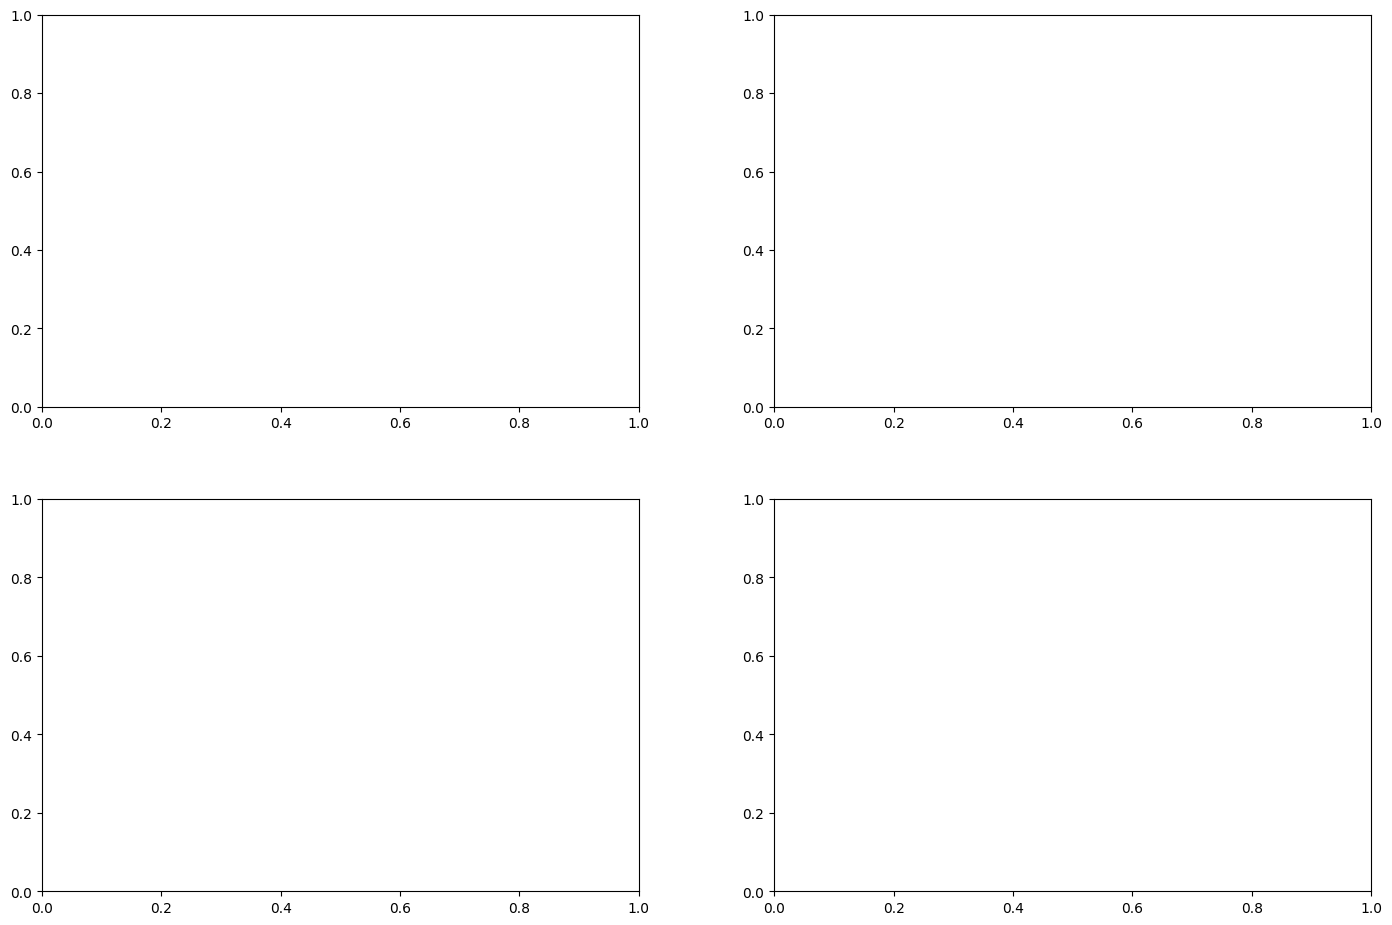

In [124]:
#RES vs ASS INF: res_vs_full
#ASS vs FULL INF: ass_full
#RES VS ASS SE : rs_ass_se
#ASS VS FULL SE: ass_full_se


fig, ( (ax_one,ax_two),(ax_three,ax_four)) = plt.subplots(nrows=2,ncols=2)
axes= [ax_one,ax_two,ax_three,ax_four]

fig = plt.gcf()
fig.tight_layout()
fig.set_size_inches(15,10)

dihigh_ra_se = {}
dilow_ra_se = {}
nmenlow_ra_se = {}
nwomenlow_ra_se ={}
nmenhigh_ra_se = {}
nwomenhigh_ra_se = {}

dihigh_af_se = {}
dilow_af_se = {}
nmenlow_af_se = {}
nwomenlow_af_se ={}
nmenhigh_af_se = {}
nwomenhigh_af_se = {}

dihigh_ra_all = {}
dilow_ra_all = {}
nmenlow_ra_all = {}
nwomenlow_ra_all ={}
nmenhigh_ra_all = {}
nwomenhigh_ra_all = {}


dihigh_af_all = {}
dilow_af_all = {}
nmenlow_af_all = {}
nwomenlow_af_all ={}
nmenhigh_af_all = {}
nwomenhigh_af_all = {}



for y in res_vs_ass_full.year.unique():
    dihigh_ra_se[y] = rs_ass_se.loc[(rs_ass_se.year == y) & (rs_ass_se['class'] == 'high'),'DI'].item()
    dilow_ra_se[y] = rs_ass_se.loc[(rs_ass_se.year == y) & (rs_ass_se['class'] == 'low'),'DI'].item()
    nmenlow_ra_se[y] = rs_ass_se.loc[(rs_ass_se.year == y) & (rs_ass_se['class']=='low'),'group_size_men'].item()
    nwomenlow_ra_se[y] = rs_ass_se.loc[(rs_ass_se.year == y) & (rs_ass_se['class'] =='low'),'group_size_women'].item()
    nmenhigh_ra_se[y] = rs_ass_se.loc[(rs_ass_se.year == y) & (rs_ass_se['class'] =='high'),'group_size_men'].item()
    nwomenhigh_ra_se[y] = rs_ass_se.loc[(rs_ass_se.year == y) & (rs_ass_se['class'] =='high'),'group_size_women'].item()

    dihigh_af_se[y] = ass_full_se.loc[(ass_full_se.year == y) & (ass_full_se['class'] == 'high'),'DI'].item()
    dilow_af_se[y] = ass_full_se.loc[(ass_full_se.year == y) & (ass_full_se['class'] == 'low'),'DI'].item()
    nmenlow_af_se[y] = ass_full_se.loc[(ass_full_se.year == y) & (ass_full_se['class']=='low'),'group_size_men'].item()
    nwomenlow_af_se[y] = ass_full_se.loc[(ass_full_se.year == y) & (ass_full_se['class'] =='low'),'group_size_women'].item()
    nmenhigh_af_se[y] = ass_full_se.loc[(ass_full_se.year == y) & (ass_full_se['class'] =='high'),'group_size_men'].item()
    nwomenhigh_af_se[y] = ass_full_se.loc[(ass_full_se.year == y) & (ass_full_se['class'] =='high'),'group_size_women'].item()

    dihigh_ra_all[y] = res_vs_ass_full.loc[(res_vs_ass_full.year == y) & (res_vs_ass_full['class'] == 'high'),'DI'].item()
    dilow_ra_all[y] = res_vs_ass_full.loc[(res_vs_ass_full.year == y) & (res_vs_ass_full['class'] == 'low'),'DI'].item()
    nmenlow_ra_all[y] = res_vs_ass_full.loc[(res_vs_ass_full.year == y) & (res_vs_ass_full['class']=='low'),'group_size_men'].item()
    nwomenlow_ra_all[y] = res_vs_ass_full.loc[(res_vs_ass_full.year == y) & (res_vs_ass_full['class'] =='low'),'group_size_women'].item()
    nmenhigh_ra_all[y] = res_vs_ass_full.loc[(res_vs_ass_full.year == y) & (res_vs_ass_full['class'] =='high'),'group_size_men'].item()
    nwomenhigh_ra_all[y] = res_vs_ass_full.loc[(res_vs_ass_full.year == y) & (res_vs_ass_full['class'] =='high'),'group_size_women'].item()

    dihigh_af_all[y] = ass_full.loc[(ass_full.year == y) & (ass_full['class'] == 'high'),'DI'].item()
    dilow_af_all[y] = ass_full.loc[(ass_full.year == y) & (ass_full['class'] == 'low'),'DI'].item()
    nmenlow_af_all[y] = ass_full.loc[(ass_full.year == y) & (ass_full['class']=='low'),'group_size_men'].item()
    nwomenlow_af_all[y] = ass_full.loc[(ass_full.year == y) & (ass_full['class'] =='low'),'group_size_women'].item()
    nmenhigh_af_all[y] = ass_full.loc[(ass_full.year == y) & (ass_full['class'] =='high'),'group_size_men'].item()
    nwomenhigh_af_all[y] = ass_full.loc[(ass_full.year == y) & (ass_full['class'] =='high'),'group_size_women'].item()



ax2 = ax_one.twinx()
ax2.set_axisbelow(True)

#ONLY BEST PERCENTILE, INFra / SEra / INFaf / SEaf

ax_one.plot(list(dihigh_ra_all.keys()),list(dihigh_ra_all.values()), 'g', linestyle='solid', label='Disparate Impact (RA)',)
ax2.plot(list(nmenhigh_ra_all.keys()),list(nmenhigh_ra_all.values()),  color='blue', linestyle='dashed', alpha=0.8, label='Men (RA)')
ax2.plot(list(nwomenhigh_ra_all.keys()),list(nwomenhigh_ra_all.values()),color='orange', linestyle='dashed', alpha=0.8, label='Women (RA)')

#ax_one.set_xlabel('Year')
ax_one.set_ylabel('Disparate Impact', color='g')
#ax2.set_ylabel('Set Cardinality', color='b')
ax_one.set_title("INF Community Best Performers \n \n" + r" $(INF_{RA})$ ")

ax2 = ax_two.twinx()
ax2.set_axisbelow(True)

#ONLY BEST PERCENTILE, INFra / SEra / INFaf / SEaf

ax_two.plot(list(dihigh_ra_se.keys()),list(dihigh_ra_se.values()), 'g', linestyle='solid', label='Disparate Impact (RA)',)
ax2.plot(list(nmenhigh_ra_se.keys()),list(nmenhigh_ra_se.values()),  color='blue', linestyle='dashed', alpha=0.8, label='Men (RA)')
ax2.plot(list(nwomenhigh_ra_se.keys()),list(nwomenhigh_ra_se.values()),color='orange', linestyle='dashed', alpha=0.8, label='Women (RA)')

#ax_two.set_xlabel('Year')
#ax_two.set_ylabel('Disparate Impact', color='g')
ax2.set_ylabel('Set Cardinality', color='b')
ax_two.set_title("SE Community Best Performers \n \n" + r" $(SE_{RA})$ ")

#ONLY BEST PERCENTILE, INFra / SEra / INFaf / SEaf

ax2 = ax_three.twinx()
ax2.set_axisbelow(True)

ax_three.plot(list(dihigh_af_all.keys()),list(dihigh_af_all.values()), 'g', linestyle='solid', label='Disparate Impact (RA)',)
ax2.plot(list(nmenhigh_af_all.keys()),list(nmenhigh_af_all.values()),  color='blue', linestyle='dashed', alpha=0.8, label='Men (RA)')
ax2.plot(list(nwomenhigh_af_all.keys()),list(nwomenhigh_af_all.values()),color='orange', linestyle='dashed', alpha=0.8, label='Women (RA)')

ax_three.set_xlabel('Year')
ax_three.set_ylabel('Disparate Impact', color='g')
ax_three.set_yticks([0.75,0.8,0.85,0.9,0.95])
#ax2.set_ylabel('Set Cardinality', color='b')
ax_three.set_title( r" $(INF_{AF})$ ")



#ONLY BEST PERCENTILE, INFra / SEra / INFaf / SEaf

ax2 = ax_four.twinx()
ax2.set_axisbelow(True)

ax_four.plot(list(dihigh_af_se.keys()),list(dihigh_af_se.values()), 'g', linestyle='solid', label='Disparate Impact (RA)',)
ax2.plot(list(nmenhigh_af_se.keys()),list(nmenhigh_af_se.values()),  color='blue', linestyle='dashed', alpha=0.8, label='Men (RA)')
ax2.plot(list(nwomenhigh_af_se.keys()),list(nwomenhigh_af_se.values()),color='orange', linestyle='dashed', alpha=0.8, label='Women (RA)')

ax_four.set_xlabel('Year')
#ax_four.set_ylabel('Disparate Impact', color='g')
ax2.set_ylabel('Set Cardinality', color='b')
ax_four.set_title(r" $(SE_{AF})$ ")


handles3, labels3 = ax2.get_legend_handles_labels()
fig.tight_layout()
handles, labels = ax_four.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles = handles + handles2 + handles3
labels = labels + labels2 + labels3

fig.tight_layout()
plt.subplots_adjust(bottom=0.2)
fig.legend(handles, ['Disparate Impact', 'Men', 'Women'], loc='lower center',ncol=3)
fig.savefig('grid_high.pdf', type='pdf', bbox_inches='tight')
fig.savefig('grid_high.png', type='png', bbox_inches='tight')